**This notebook is an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/the-sliding-window).**

---


# Introduction #

In these exercises, you'll explore the operations a couple of popular convnet architectures use for feature extraction, learn about how convnets can capture large-scale visual features through stacking layers, and finally see how convolution can be used on one-dimensional data, in this case, a time series.

Run the cell below to set everything up.

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex4 import *

import tensorflow as tf
import matplotlib.pyplot as plt
import learntools.computer_vision.visiontools as visiontools


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# (Optional) Experimenting with Feature Extraction #

This exercise is meant to give you an opportunity to explore the sliding window computations and how their parameters affect feature extraction. There aren't any right or wrong answers -- it's just a chance to experiment!

We've provided you with some images and kernels you can use. Run this cell to see them.

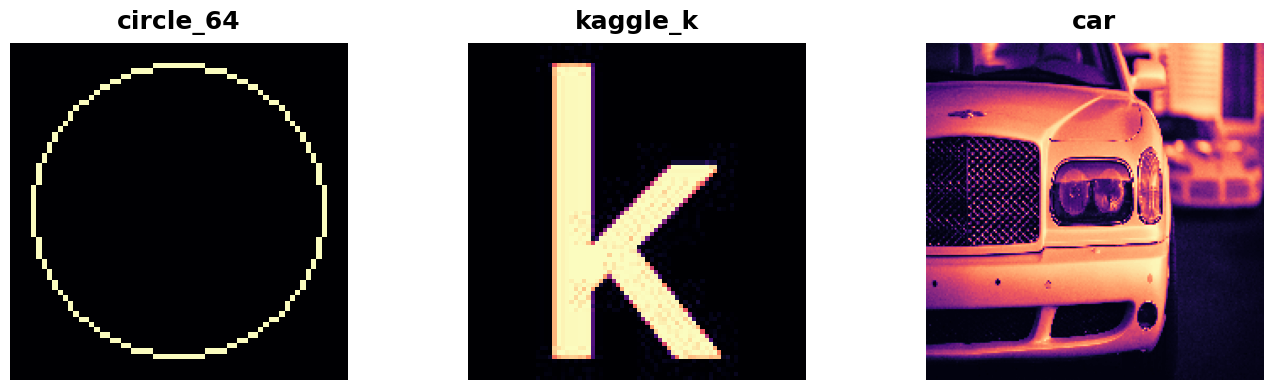

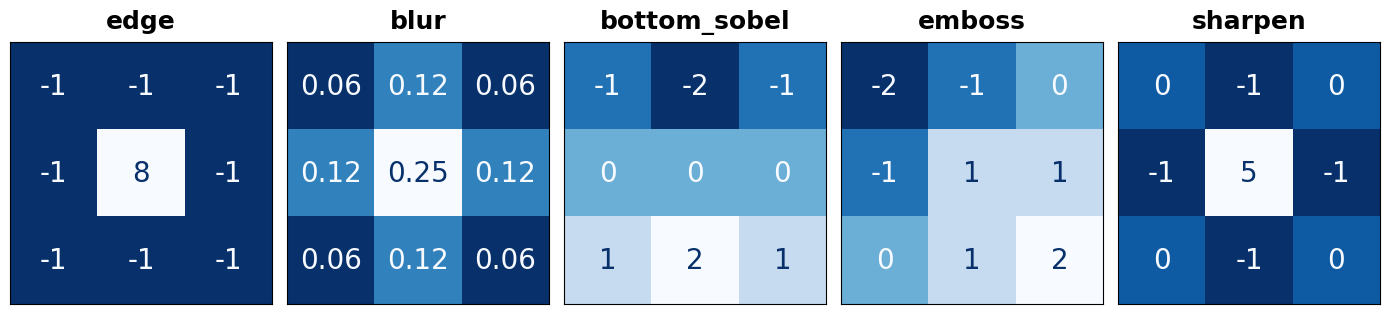

In [2]:
from learntools.computer_vision.visiontools import edge, blur, bottom_sobel, emboss, sharpen, circle

image_dir = '../input/computer-vision-resources/'
circle_64 = tf.expand_dims(circle([64, 64], val=1.0, r_shrink=4), axis=-1)
kaggle_k = visiontools.read_image(image_dir + str('k.jpg'), channels=1)
car = visiontools.read_image(image_dir + str('car_illus.jpg'), channels=1)
car = tf.image.resize(car, size=[200, 200])
images = [(circle_64, "circle_64"), (kaggle_k, "kaggle_k"), (car, "car")]

plt.figure(figsize=(14, 4))
for i, (img, title) in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(tf.squeeze(img))
    plt.axis('off')
    plt.title(title)
plt.show();

kernels = [(edge, "edge"), (blur, "blur"), (bottom_sobel, "bottom_sobel"),
           (emboss, "emboss"), (sharpen, "sharpen")]
plt.figure(figsize=(14, 4))
for i, (krn, title) in enumerate(kernels):
    plt.subplot(1, len(kernels), i+1)
    visiontools.show_kernel(krn, digits=2, text_size=20)
    plt.title(title)
plt.show()

To choose one to experiment with, just enter it's name in the appropriate place below. Then, set the parameters for the window computation. Try out some different combinations and see what they do!

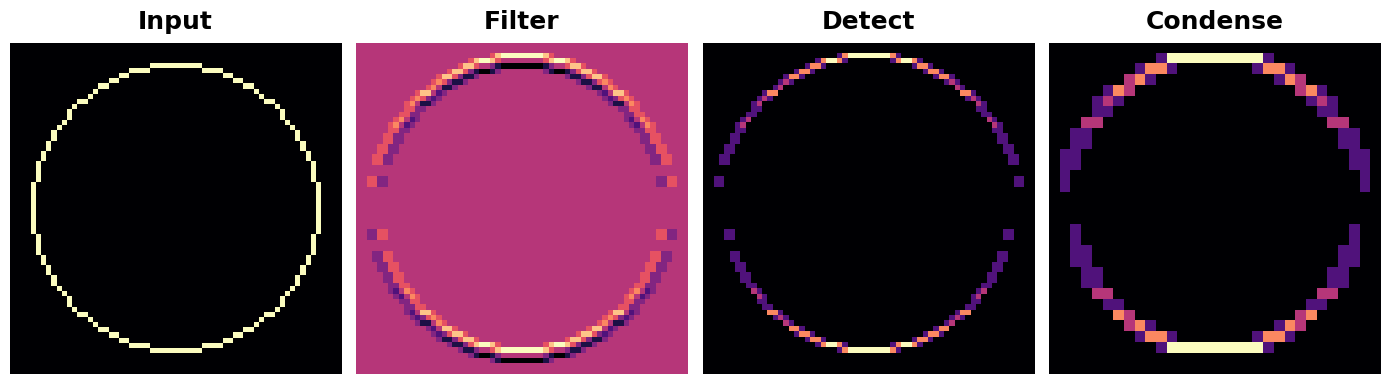

In [3]:
# YOUR CODE HERE: choose an image
image = circle_64

# YOUR CODE HERE: choose a kernel
kernel = bottom_sobel

visiontools.show_extraction(
    image, kernel,

    # YOUR CODE HERE: set parameters
    conv_stride=1,
    conv_padding='valid',
    pool_size=2,
    pool_stride=2,
    pool_padding='same',
    
    subplot_shape=(1, 4),
    figsize=(14, 6),
)

# The Receptive Field #

Trace back all the connections from some neuron and eventually you reach the input image. All of the input pixels a neuron is connected to is that neuron's **receptive field**. The receptive field just tells you which parts of the input image a neuron receives information from.

As we've seen, if your first layer is a convolution with $3 \times 3$ kernels, then each neuron in that layer gets input from a $3 \times 3$ patch of pixels (except maybe at the border).

What happens if you add another convolutional layer with $3 \times 3$ kernels? Consider this next illustration:

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HmwQm2S.png" alt="Illustration of the receptive field of two stacked convolutions." width=250>
</figure>

Now trace back the connections from the neuron at top and you can see that it's connected to a $5 \times 5$ patch of pixels in the input (the bottom layer): each neuron in the $3 \times 3$ patch in the middle layer is connected to a $3 \times 3$ input patch, but they overlap in a $5 \times 5$ patch. So that neuron at top has a $5 \times 5$ receptive field.

# 1) Growing the Receptive Field #

Now, if you added a *third* convolutional layer with a `(3, 3)` kernel, what receptive field would its neurons have? Run the cell below for an answer. (Or see a hint first!)

In [4]:
# View the solution (Run this code cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The third layer would have a $7 \times 7$ receptive field.

In [5]:
# Lines below will give you a hint
#q_1.hint()

So why stack layers like this? Three `(3, 3)` kernels have 27 parameters, while one `(7, 7)` kernel has 49, though they both create the same receptive field. This stacking-layers trick is one of the ways convnets are able to create large receptive fields without increasing the number of parameters too much. You'll see how to do this yourself in the next lesson!

# (Optional) One-Dimensional Convolution #

Convolutional networks turn out to be useful not only (two-dimensional) images, but also on things like time-series (one-dimensional) and video (three-dimensional).

We've seen how convolutional networks can learn to extract features from (two-dimensional) images. It turns out that convnets can also learn to extract features from things like time-series (one-dimensional) and video (three-dimensional).

In this (optional) exercise, we'll see what convolution looks like on a time-series.

The time series we'll use is from [Google Trends](https://trends.google.com/trends/). It measures the popularity of the search term "machine learning" for weeks from January 25, 2015 to January 15, 2020.

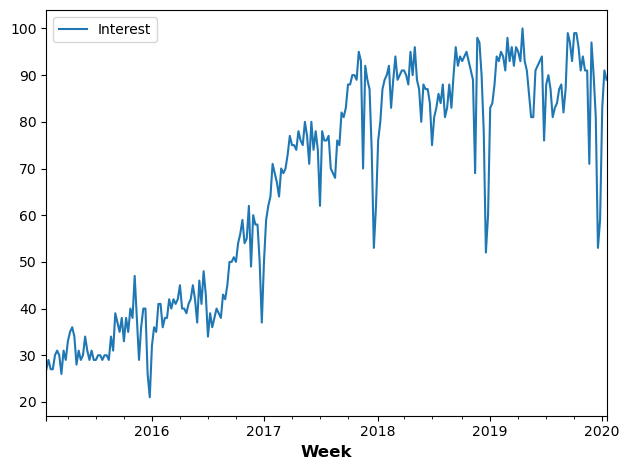

In [6]:
import pandas as pd

# Load the time series as a Pandas dataframe
machinelearning = pd.read_csv(
    '../input/computer-vision-resources/machinelearning.csv',
    parse_dates=['Week'],
    index_col='Week',
)

machinelearning.plot();

What about the kernels? Images are two-dimensional and so our kernels were 2D arrays. A time-series is one-dimensional, so what should the kernel be? A 1D array! Here are some kernels sometimes used on time-series data:

In [7]:
detrend = tf.constant([-1, 1], dtype=tf.float32)

average = tf.constant([0.2, 0.2, 0.2, 0.2, 0.2], dtype=tf.float32)

spencer = tf.constant([-3, -6, -5, 3, 21, 46, 67, 74, 67, 46, 32, 3, -5, -6, -3], dtype=tf.float32) / 320

Convolution on a sequence works just like convolution on an image. The difference is just that a sliding window on a sequence only has one direction to travel -- left to right -- instead of the two directions on an image. And just like before, the features picked out depend on the pattern on numbers in the kernel.

Can you guess what kind of features these kernels extract? Uncomment one of the kernels below and run the cell to see!

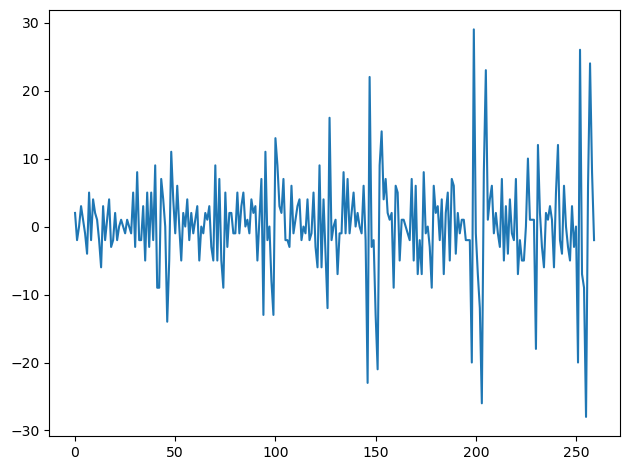

In [8]:
# UNCOMMENT ONE
kernel = detrend
# kernel = average
# kernel = spencer

# Reformat for TensorFlow
ts_data = machinelearning.to_numpy()
ts_data = tf.expand_dims(ts_data, axis=0)
ts_data = tf.cast(ts_data, dtype=tf.float32)
kern = tf.reshape(kernel, shape=(*kernel.shape, 1, 1))

ts_filter = tf.nn.conv1d(
    input=ts_data,
    filters=kern,
    stride=1,
    padding='VALID',
)

# Format as Pandas Series
machinelearning_filtered = pd.Series(tf.squeeze(ts_filter).numpy())

machinelearning_filtered.plot();

In fact, the `detrend` kernel filters for *changes* in the series, while `average` and `spencer` are both "smoothers" that filter for low-frequency components in the series.

If you were interested in predicting the future popularity of search terms, you might train a convnet on time-series like this one. It would try to learn what features in those series are most informative for the prediction.

Though convnets are not often the best choice on their own for these kinds of problems, they are often incorporated into other models for their feature extraction capabilities.

# Conclusion #

This lesson ends our discussion of feature extraction. Hopefully, having completed these lessons, you've gained some intuition about how the process works and why the usual choices for its implementation are often the best ones.

# Keep Going #

In the next lesson, [**Lesson 5**](https://www.kaggle.com/ryanholbrook/custom-convnets), you'll learn how to compose the `Conv2D` and `MaxPool2D` layers to build your own convolutional networks from scratch.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*